In [1]:
from MALDIMap import MALDINet
from MALDIMap.utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import gc
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='3'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

In [3]:
root_path = '/raid/lzyt_dir/Data/'#质谱csv和标签路径
save_path = '/mnt/lzyt/SmallSamples'#mp和X保存路径

## Data_11 共1个任务  布鲁氏菌 suis：abortus：melitensis = 12：11：21

### 固定训练集：测试集 =  7： 3

In [4]:
dfx = LoadMSData(root_path = root_path, data_path = 'data13/peaks.csv', t = False)
#Train Labels loading
train_Y = np.zeros((32,3))                                       #将标签以独热编码存起来32
test_Y = np.zeros(32)                                            #用于分层测试的标签
for i in range (0,9):                                           #suis 9例
    train_Y[i,0] = 1
    test_Y[i] = 0  
for i in range (9,17):                                          #abortus 8例
    train_Y[i,1] = 1
    test_Y[i] = 1 
for i in range (17,32):                                         #melitensis 15例
    train_Y[i,2] = 1
    test_Y[i] = 2 

y = train_Y.astype(int)
Y = test_Y.astype(int)

In [5]:
mp = AggMap(dfx, metric = 'euclidean')                        #使用欧式距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data11', file_type = 'aggmap', file_name = 'aggmap.mp')

2024-01-02 16:51:38,331 - INFO - [bidd-aggmap] - Calculating distance ...
2024-01-02 16:51:38,355 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 436/436 [00:00<00:00, 603.93it/s]


2024-01-02 16:51:43,584 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2024-01-02 16:51:47,756 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2024-01-02 16:51:47,996 - INFO - [bidd-aggmap] - Finished


In [6]:
dfx_train = LoadMSData(root_path = root_path, data_path = 'data13/peaks_train.csv', t = False)
dfx_test = LoadMSData(root_path = root_path, data_path = 'data13/peaks_test.csv', t = False)
#Test Labels loading
test_Y = np.zeros(12)                                            #用于测试的标签
for i in range (0,3):                                           #suis 3例
    test_Y[i] = 0  
for i in range (3,6):                                          #abortus 3例
    test_Y[i] = 1 
for i in range (6,12):                                         #melitensis 6例
    test_Y[i] = 2 

ex_y = test_Y.astype(int)

In [7]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx_train.values, n_jobs=4, scale_method = 'minmax')
ex_X = mp.batch_transform(dfx_test.values, n_jobs=4, scale_method = 'minmax')
#SaveMpOrX(data = X, save_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_human_0.2.dat')

100%|##########| 12/12 [00:00<00:00, 269.45it/s]


y_pred is  [0 0 0 1 1 1 2 2 2 2 2 2]
y_true is  [0 0 0 1 1 1 2 2 2 2 2 2]
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


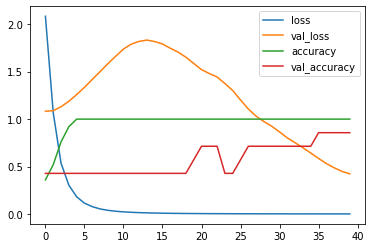

y_pred is  [0 0 0 1 1 1 2 2 2 2 2 2]
y_true is  [0 0 0 1 1 1 2 2 2 2 2 2]
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


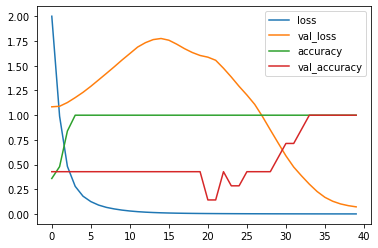

y_pred is  [0 0 0 1 1 1 2 2 2 2 2 2]
y_true is  [0 0 0 1 1 1 2 2 2 2 2 2]
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


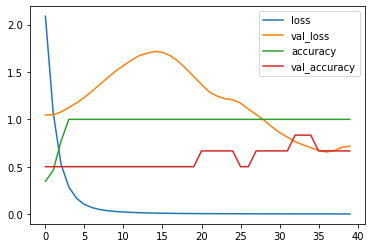

y_pred is  [0 0 0 1 1 1 2 2 2 2 2 2]
y_true is  [0 0 0 1 1 1 2 2 2 2 2 2]
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


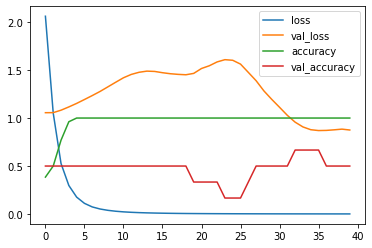

y_pred is  [0 0 0 1 1 1 2 2 2 2 2 2]
y_true is  [0 0 0 1 1 1 2 2 2 2 2 2]
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


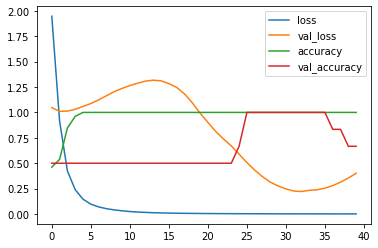

1.0

In [8]:
#三核 四折交叉验证最佳结果
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,val_index in outer.split(X,Y):
    train_X,val_X = X[train_index],X[val_index]
    train_Y,val_y = y[train_index],y[val_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128,64],batch_size=128,epochs=40,gpuid=3)
    clf.fit(train_X, train_Y,X_val = val_X,y_val = val_y)

    y_pred = clf.predict(ex_X)
    #MADLINet Test Metrics
    #auc = roc_auc_score(test_y, y_pred)
    print('y_pred is ',y_pred)
    print('y_true is ',ex_y)
    acc = accuracy_score(ex_y,y_pred)
    rec = recall_score(ex_y, y_pred,average="micro")
    f1 = f1_score(ex_y, y_pred,average="micro")
    pr = precision_score(ex_y, y_pred,average="micro")
    #print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 5